In [1]:
import sys
import os
sys.path.append("src")

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import wavelet_transform as wt
from pygsp import graphs
from time import time

In [2]:
if not os.path.exists("figs"):
    os.makedirs("figs")

In [26]:
def plot_graph_signal(
        G,
        signal,
        pos = None,
        vmin = None,
        vmax = None,
        ax = None,
        fig = None,
        colorbar = True,
        colorbar_label = "Values",
    ):
    if ax is None:
        fig, ax = plt.subplots(figsize = (4, 4))
    
    vmin = np.min(signal) if vmin is None else vmin
    vmax = np.max(signal) if vmax is None else vmax
   
    pathcollection = nx.draw_networkx_nodes(
        G, 
        pos, 
        node_color=signal,
        cmap=plt.cm.magma, 
        node_size=50,
        edgecolors="#909090",
        ax = ax,
        vmin = vmin,
        vmax = vmax
    )
    nx.draw_networkx_edges(
        G, 
        pos,
        edge_color="#909090", 
        ax = ax
    )
    
    ax.axis("off")
    if colorbar:
        fig.colorbar(pathcollection, ax = ax, label = colorbar_label)
        ax.figure.axes[-1].yaxis.label.set_size(14)
    return ax
    

## Creating Graph

In [4]:
def create_grid_graph(size = 17):
    g = nx.grid_2d_graph(size, size)
    nodes = list(g.nodes)
    pos = {node: node for node in g.nodes}
    pos = np.array(list(pos.values()))
    for node in nodes:
        # get node position
        node_pos = np.array(node)
        # get all nodes closest than \sqrt 2
        distances = np.linalg.norm(pos - node_pos, axis = 1)
        idx_close = (distances < 2) & (distances != 0) & (distances != 1)
        close_node = np.random.choice(np.where(idx_close)[0])

        # select a random close node
        n1 = close_node

        # add edge
        g.add_edge(node, tuple(nodes[n1]))

    return g

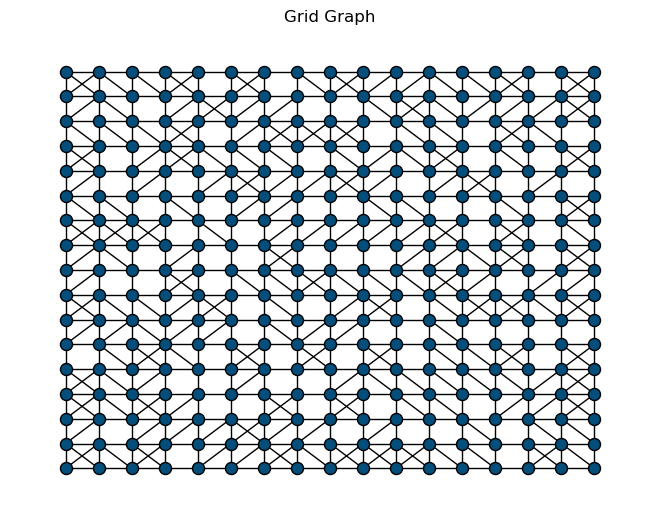

In [5]:
# create 2D grid graph
np.random.seed(1)
g = create_grid_graph(17)


adj_matrix = nx.adjacency_matrix(g).todense()

# darw nodes by position
pos = {node: node for node in g.nodes}
pos = np.array(list(pos.values()))
# add random noise
#pos = pos + np.random.normal(0, 0.15, pos.shape)
pos = {node: pos[i] for i, node in enumerate(g.nodes)}
nx.draw(g, pos, node_size = 75, node_color = "#034e7b", edgecolors = "black", width = 1)
plt.axis("off")
plt.title("Grid Graph")
plt.savefig("figs/grid_graph.pdf", dpi = 300)

## Fourier Transform

In [6]:
G = graphs.Graph(adj_matrix)
G.compute_fourier_basis()

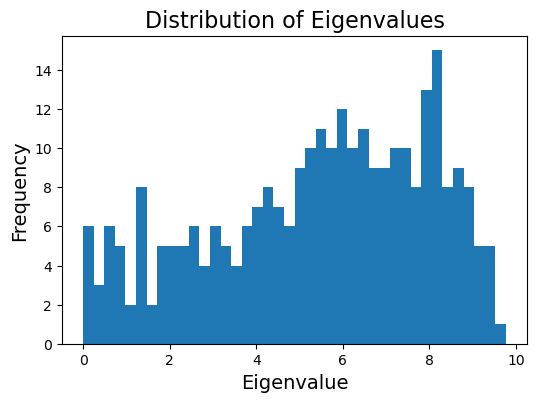

In [23]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 4))
ax.hist(G.e, bins = 40)
ax.set_title("Distribution of Eigenvalues", fontsize = 16)
ax.set_xlabel("Eigenvalue", fontsize = 14)
ax.set_ylabel("Frequency", fontsize = 14)
plt.savefig("figs/eigenvalues_dist.svg", dpi = 300)
plt.show()

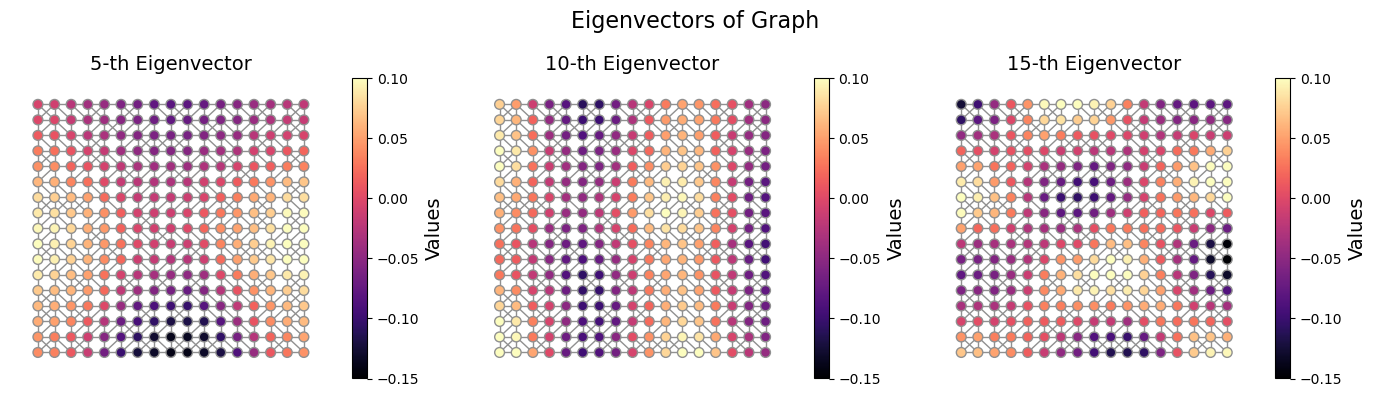

In [25]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (14, 4))
for i, idx in enumerate([4, 9, 14]):
    plot_graph_signal(
        g, 
        G.U[:, idx], 
        pos = pos, 
        ax = axs[i],
        vmin = -0.15,
        vmax = 0.10,
        fig=fig
    )
    axs[i].set_title(f"{idx+1}-th Eigenvector", fontsize = 14)
   
plt.suptitle("Eigenvectors of Graph", fontsize = 16)
plt.tight_layout()
plt.savefig("figs/eigenvectors.svg", dpi = 300)
plt.show()

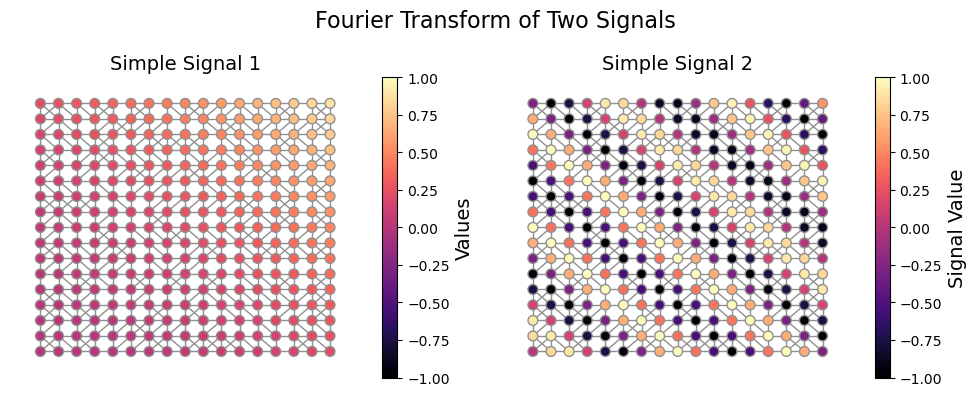

In [28]:
simple_signal = np.zeros((2, 17, 17))

for i in range(17):
    for j in range(17):
        simple_signal[0, i, j] = (i + j)**2 / (34)**2
        simple_signal[1, i, j] = np.sin(i + j)

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
plot_graph_signal(
    g, 
    simple_signal[0].flatten(), 
    pos = pos, 
    ax = axs[0],
    vmin = -1,
    vmax = 1,
    fig=fig
)

plot_graph_signal(
    g, 
    simple_signal[1].flatten(), 
    pos = pos, 
    ax = axs[1],
    vmin = -1,
    vmax = 1,
    fig=fig,
    colorbar_label="Signal Value"
)

axs[0].set_title("Simple Signal 1", fontsize = 14)
axs[1].set_title("Simple Signal 2", fontsize = 14)

plt.suptitle("Fourier Transform of Two Signals", fontsize = 16)
plt.tight_layout()
plt.savefig("figs/simple_signals.svg", dpi = 300)

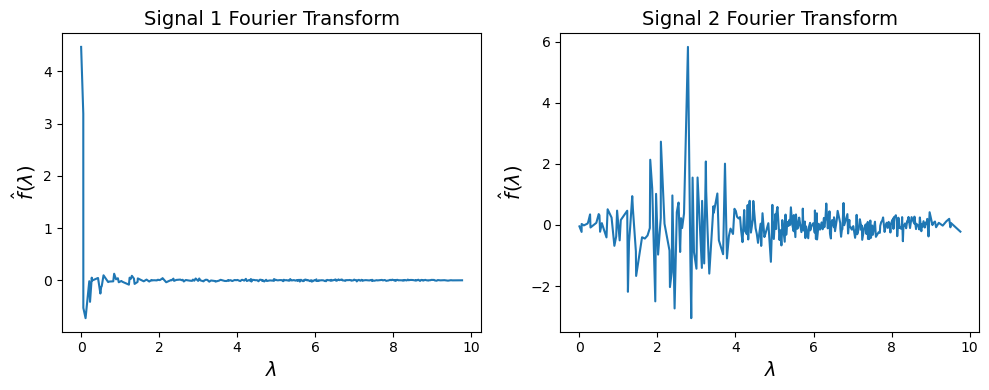

In [32]:
transformed_signal = [G.gft(signal.flatten()) for signal in simple_signal]

fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))

for i in range(2):
    axs[i].plot(G.e, transformed_signal[i])
    axs[i].set_ylabel("$\hat f(\lambda)$", fontsize = 14)
    axs[i].set_xlabel("$\lambda$", fontsize = 14)
    axs[i].set_title(f"Signal {i+1} Fourier Transform", fontsize = 14)
#plt.suptitle("Graph Fourier Transform of Signals")
plt.tight_layout()
plt.savefig("figs/fourier_transform.svg", dpi = 300)
plt.show() 


## Graph Wavelet Transform

In [62]:
signal = np.random.normal(0, 0.25, (17, 17)) + 3

for i in range(17):
    for j in range(17):
        if (i - 8)**2 + (j - 8)**2 <= 25:
            signal[i, j] += 3

signal = signal.flatten()

adj_matrix = np.array(nx.adjacency_matrix(g).todense())
wav = wt.WaveletTransform(
    adj_matrix = adj_matrix,
    n_timestamps=1,
    method = "exact_fast",
    scaling_function=False,
    n_filters=4
)
coeffs = wav.transform(signal.reshape(-1, 1))
coeffs_ = coeffs.reshape(17, 17, 4)

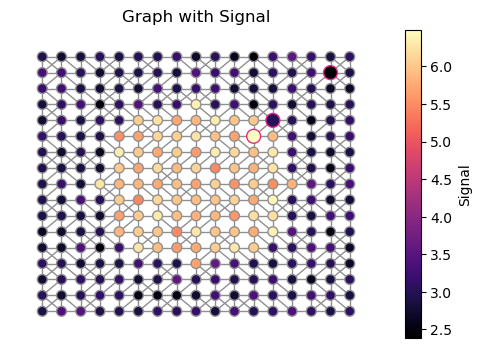

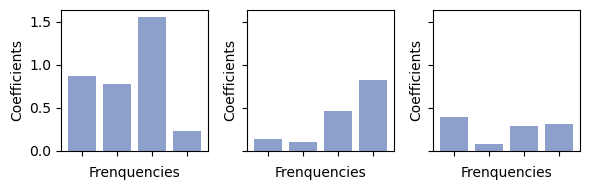

In [65]:
selected_nodes = [
    [11, 11],
    [12, 12],
    [15, 15],
]
selected_nodes_idx = [ x + y * 17 for (x, y) in selected_nodes]
fig = plt.figure(figsize = (6, 4))
pathcollection = nx.draw_networkx_nodes(
    g, 
    pos, 
    node_color=signal, 
    cmap=plt.cm.magma, 
    node_size=[100 if i in selected_nodes_idx else 50 for i in range(len(pos))],
    edgecolors=["#e7298a" if i in selected_nodes_idx else "#909090" for i in range(len(pos))],
    #vmin = 1
)
nx.draw_networkx_edges(g, pos, edge_color="#909090")
plt.colorbar(pathcollection, label = "Signal")
plt.title("Graph with Signal")
plt.axis("off")
plt.savefig("figs/graph_with_signal.svg", dpi = 300)
plt.show()



fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize =(6, 2), sharex = True, sharey = True)

for i in range(3):
    c = np.abs(coeffs_[selected_nodes[i][0], selected_nodes[i][1], :])
    axs[i].bar(range(4), c, color = "#8da0cb")

    axs[i].set_xticks(range(4), labels = ["" for _ in range(4)])
    #axs[i].set_yticks([])
    axs[i].set_xlabel("Frenquencies")
    axs[i].set_ylabel("Coefficients")

plt.tight_layout()
plt.savefig("figs/coefs.svg", dpi = 300)
plt.show()

## Fast Computation

In [32]:
graph_sizes = [5, 10, 15, 20, 25, 30]
exact_time = []
cheb_time = []
cheb_error = []

for n_g in graph_sizes:
    signal = np.random.random((n_g**2, 20))
    g = create_grid_graph(n_g)
    adj_matrix = nx.adjacency_matrix(g).todense()
    times_ = []
    for _ in range(10):
        start = time()
        wav = wt.WaveletTransform(
            adj_matrix = adj_matrix,
            n_timestamps=20,
            method = "exact_low_memory",
            scaling_function=False,
            n_filters=4
        )
        coeffs_exact = wav.transform(signal)
        end = time()
        times_.append(end - start)
    exact_time.append(np.mean(times_))

    times_ = []
    for _ in range(10):
        start = time()
        wav = wt.WaveletTransform(
            adj_matrix = adj_matrix,
            n_timestamps=20,
            method = "chebyshev",
            scaling_function=False,
            n_filters=4
        )
        coeffs_cheb = wav.transform(signal)
        end = time()
        times_.append(end - start)
    cheb_time.append(np.mean(times_))
    cheb_error.append(np.mean(np.abs(coeffs_exact - coeffs_cheb) / np.abs(coeffs_exact)))


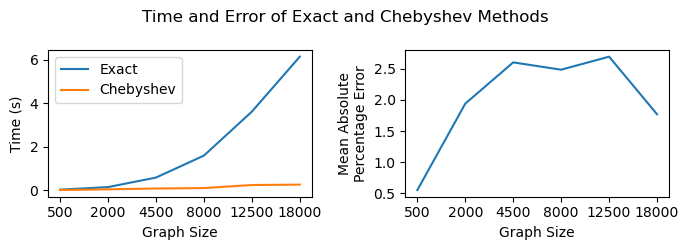

In [33]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (7, 2.5))
axs[0].plot(graph_sizes, exact_time, label = "Exact")
axs[0].plot(graph_sizes, cheb_time, label = "Chebyshev")

axs[1].plot(graph_sizes, cheb_error, label = "Chebyshev")
for i in range(2):
    axs[i].set_xlabel("Graph Size")
    axs[i].set_xticks(graph_sizes, labels = [int(x*x*20) for x in graph_sizes])
axs[0].set_ylabel("Time (s)")
axs[0].legend()
axs[1].set_ylabel("Mean Absolute\nPercentage Error")
plt.suptitle("Time and Error of Exact and Chebyshev Methods")
plt.tight_layout()
plt.savefig("figs/time_error.pdf", dpi = 300)
plt.show()

In [49]:
n_order = [10, 20, 30, 40, 50]
cheb_time = []
cheb_error = []

g = create_grid_graph(17)
adj_matrix = nx.adjacency_matrix(g).todense()
signal = np.random.random((17**2, 20))
wav = wt.WaveletTransform(
    adj_matrix = adj_matrix,
    n_timestamps=20,
    method = "exact_low_memory",
    scaling_function=False,
    n_filters=4
)
coeffs_exact = wav.transform(signal)

for order in n_order:
    times_ = []
    for i in range(10):
        start = time()
        wav = wt.WaveletTransform(
            adj_matrix = adj_matrix,
            n_timestamps=20,
            method = "chebyshev",
            scaling_function=False,
            n_filters=4,
            order_chebyshev=order,
        )
        coeffs_cheb = wav.transform(signal)
        end = time()
        times_.append(end - start)
    cheb_time.append(np.mean(times_))
    # append MAPE
    cheb_error.append(np.mean(np.abs(coeffs_exact - coeffs_cheb) / np.abs(coeffs_exact)))


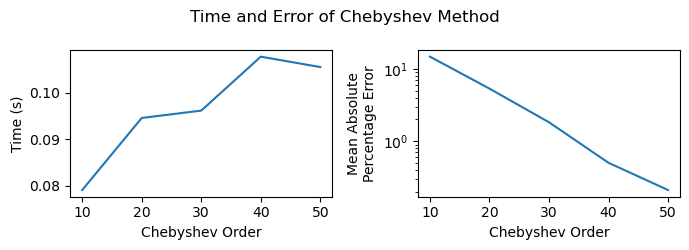

In [50]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (7, 2.5))

axs[0].plot(n_order, cheb_time, label = "Chebyshev")
axs[1].plot(n_order, cheb_error, label = "Chebyshev")

for i in range(2):
    axs[i].set_xlabel("Chebyshev Order")
    axs[i].set_xticks(n_order)
axs[0].set_ylabel("Time (s)")
axs[1].set_ylabel("Mean Absolute\nPercentage Error")
axs[1].set_yscale("log")
plt.suptitle("Time and Error of Chebyshev Method")
plt.tight_layout()
plt.savefig("figs/time_error_cheb_order.pdf", dpi = 300)
plt.show()